<a href="https://colab.research.google.com/github/liao771018/Team-Project/blob/main/TeanProject_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Aug  2 04:44:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import os
from glob import glob

from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, losses, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare dataset

In [ ]:
# 模型要用的圖片大小
IMG_SIZE = 224

# 模型檔名
model_name = 'CNN_TP_ppt_2.h5'

# 記錄檔名
log_name = 'CNN_logs_ppt_2.csv'

# 模型存檔的位置
save_model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/01_CNN'

model_path = save_model_path + '/' + model_name
log_path = save_model_path + '/' + log_name

In [ ]:
# 讀取資料
img_dir = '/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片'

trains = glob(img_dir + '/train/*')
tests = glob(img_dir + '/test/*')

print('train:', len(trains))
print('test:', len(tests))

train: 6088
test: 838


/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片/train/octopus_crawler_01286.jpg
shape: (453, 805, 3)
resize shape: (224, 224, 3)
class: octopus


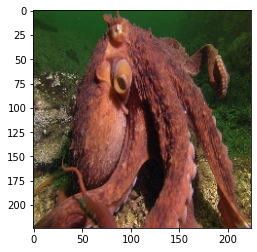

In [ ]:
# 拿一張出來看看
idx = np.random.randint(0, len(trains))
print(trains[idx])

# cv2 讀取是 BGR plt 顯示是 RGB
img = cv2.imread(trains[idx])[:,:,::-1]
print('shape:', img.shape)

# 改變 shape
img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
print('resize shape:', img_resize.shape)

cls = trains[idx].split('/')[-1].split('_')[0]
print('class:', cls)

plt.imshow(img_resize)

In [ ]:
img = np.array(img) / 255.0
img

array([[[0.11764706, 0.28627451, 0.10980392],
        [0.11372549, 0.28235294, 0.10588235],
        [0.11372549, 0.28235294, 0.10196078],
        ...,
        [0.14901961, 0.18823529, 0.05098039],
        [0.14509804, 0.18431373, 0.04705882],
        [0.14509804, 0.18431373, 0.04705882]],

       [[0.11764706, 0.28627451, 0.10980392],
        [0.11372549, 0.28235294, 0.10588235],
        [0.11372549, 0.28235294, 0.10196078],
        ...,
        [0.14901961, 0.18823529, 0.05098039],
        [0.14901961, 0.18823529, 0.05098039],
        [0.14901961, 0.18823529, 0.05098039]],

       [[0.11764706, 0.28627451, 0.10980392],
        [0.11372549, 0.28235294, 0.10588235],
        [0.11372549, 0.28235294, 0.10196078],
        ...,
        [0.15294118, 0.19215686, 0.05882353],
        [0.15686275, 0.19607843, 0.0627451 ],
        [0.15686275, 0.19607843, 0.0627451 ]],

       ...,

       [[0.37647059, 0.30196078, 0.17647059],
        [0.3372549 , 0.2627451 , 0.1372549 ],
        [0.29019608, 0

In [ ]:
# 把題目跟答案做成 DataFrame
train_df = pd.DataFrame({
              'img_path': trains,                  
})
test_df = pd.DataFrame({
              'img_path': tests
})


def ans(img_path):
  # 取出藏在檔名的答案
  label = img_path.split('/')[-1].split('_')[0]
  return label


train_df['label'] = train_df['img_path'].apply(ans)
test_df['label'] = test_df['img_path'].apply(ans)

train_df

,img_path,label
0,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
1,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
2,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
3,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
4,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,bigfin squid
...,...,...
6083,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
6084,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
6085,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus
6086,/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_...,octopus


In [ ]:
# 轉換答案的字典
cls = train_df['label'].unique()

cls2idx = {c: i for i, c in enumerate(cls)}
idx2cls = {i: c for i, c in enumerate(cls)}

cls2idx, idx2cls

({'bigfin squid': 0,
  'cuttlefish': 4,
  'neritic squid': 1,
  'octopus': 2,
  'squid': 3},
 {0: 'bigfin squid',
  1: 'neritic squid',
  2: 'octopus',
  3: 'squid',
  4: 'cuttlefish'})

In [ ]:
# 準備 train / validation / test  全部轉 np.array
x_train_path = np.array(train_df['img_path'])
y_train = np.array(train_df['label'].replace(cls2idx))

x_test_path = np.array(test_df['img_path'])
y_test = np.array(test_df['label'].replace(cls2idx))

# 從 train 裡面切分 validation 出來
x_train_path, x_val_path, y_train, y_val = train_test_split(x_train_path, y_train, test_size=0.2)

# 看一下 shape 是否一樣
x_train_path.shape, y_train.shape, x_val_path.shape, y_val.shape, x_test_path.shape, y_test.shape

((4870,), (4870,), (1218,), (1218,), (838,), (838,))

In [ ]:
# 建立批次讀圖後送進模型的函式

def get_data(x, y, batch=None):
    # x : 圖片路徑
    # y : 答案

    # 如果不是 None, 那代表是數字，取出這個數量的 idx
    # 範例 batch=20, 隨機 20 個idx
    # 如果是 None, 那就沒有隨機取, 取全部 idx
    if batch is not None:

      idx = np.random.randint(0, len(x), size=batch) # 在(0, len(x))取隨機的 size 個數 (可能取到重覆的)

      x, y = x[idx], y[idx]
      # 這時候 x, y 會是一批隨機的資料
    
    # img_pre: preprocess後的圖
    # img_ori: 原圖
    img_pre, img_ori = [], []

    for p in x:

      img = cv2.imread(p)[:,:,::-1]
      img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
      img = np.array(img)
      img_pre.append(img / 255.0)
      img_ori.append(img)

    return (np.array(img_pre), np.array(img_ori), y)


In [ ]:
# 把 validation 全部讀出來
x_val, _, y_val = get_data(x_val_path, y_val)

x_val.shape, y_val.shape

((1218, 224, 224, 3), (1218,))

#Build Model

In [ ]:
from tensorflow.keras import layers
# 建立模型架構

layers = [
      layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      layers.BatchNormalization(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),

      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),

      layers.Conv2D(256, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(256, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(256, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),

      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),

      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),

      layers.BatchNormalization(),
      layers.GlobalAveragePooling2D(),
      # layers.Flatten(),
      # layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(len(cls2idx), activation='softmax')

]

model = models.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [ ]:
# 選擇損失函數
model.compile(loss=losses.SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

#Training

In [ ]:
# EarlyStoppong 條件
stopping = 200
min_val_loss, best_val_accuracy = float("inf"), 0

# 要跑的數量
epoch = 200
batch = 100

# 一個 epoch 需要跑的 batch 次數
counts = int(len(trains)/batch) + 1

# 把紀錄蒐集起來
loss = []
accuracy = []
val_loss = []
val_accuracy = []


for e in range(epoch):

    total_loss, total_accuracy = 0, 0
    print('Epoch:', e+1, '/', epoch, end='\t')
        
    for b in tqdm(range(counts)):

        # 讀取資料
        x, _, y = get_data(x_train_path, y_train, batch=None) 

        # 以 batch 方式做訓練
        batch_loss, batch_accuracy = model.train_on_batch(x, y)
        
        total_loss += batch_loss
        total_accuracy += batch_accuracy

    # 把每一次 batch 的 loss, accuracy 做平均後放進 list
    batch_avg_loss = total_loss / counts
    batch_avg_accuracy = total_accuracy / counts

    # test
    epoch_val_loss, epoch_val_accuracy = model.test_on_batch(x_val, y_val)

    # 印出 loss, accuracy, val_loss, val_accuracy
    print("loss: {:.4f} - accuracy: {:.4f}".format(batch_avg_loss, batch_avg_accuracy), end=' - ')
    print("val_loss: {:.4f} - val_accuracy: {:.4f}".format(epoch_val_loss, epoch_val_accuracy))
    print('-' * 100)

    # 把四個值放進 list 做紀錄
    loss.append(batch_avg_loss)
    accuracy.append(batch_avg_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)

    # 啟動 EarlyStopping 條件
    if epoch_val_loss < min_val_loss:

        min_val_loss, best_val_accuracy = epoch_val_loss, epoch_val_accuracy
        patience = 0
        model.save(model_path)

    else:
        patience = patience + 1

    if patience == stopping:
        break   

print('\nThe Best', end='\n')
print("val_loss:", min_val_loss, '-', 'val_accuracy:', best_val_accuracy)

# 7/14 (2cls) best val_loss: 0.2518240809440613 - val-accuracy: - 0.9020618796348572 (Conv 256兩層)
# 7/14 (2cls) best val_loss: 0.15154021978378296 - val_accuracy: - 0.938144326210022 (Conv 256三層)

# 7/19 (5cls) best val_loss: 0.39365118741989136 - val_accuracy: 0.8590164184570312

Epoch: 1 / 200	

  0%|          | 0/61 [00:00<?, ?it/s]

# 評估

In [ ]:
df = pd.DataFrame({
        "loss" : loss,
        "accuracy" : accuracy,
        "val_loss" : val_loss,
        "val_accuracy" : val_accuracy
})

df.to_csv(log_path)
df

In [ ]:
x_test, x_test_ori, y_test = get_data(x_test_path, y_test)
x_test.shape, y_test.shape

In [ ]:
model = models.load_model(model_path)
model.evaluate(x_test, y_test)
# 7/14 (2cls) best loss: 0.1870 - accuracy: 0.9370 (Conv 256兩層)
# 7/14 (2cls) best loss: 0.2942 - accuracy: 0.9370 (Conv 256三層)

# 7/19 (5cls) best loss: 0.4469 - accuracy: 0.8401

In [ ]:
# 混淆矩陣

pre = model.predict(x_test).argmax(axis=-1)
mat = confusion_matrix(y_test, pre)

pd.DataFrame(mat,
      columns=['{}預測'.format(i) for i in cls2idx],
      index=['{}真實'.format(i) for i in cls2idx])


In [ ]:
# 預測錯誤的 index
idx = np.nonzero(pre != y_test)[0]

# 預測錯誤的 圖 正確值 與 預測值
pre_false_img = x_test_ori[idx]
pre_false_label = y_test[idx]
pre_false_pred = pre[idx]

# 設定圖的大小
plt.figure(figsize=(15,65))
width = 6
height = len(idx) // width + 1


# 印出來看一下預測錯誤的圖
for i in range(len(idx)):

    plt.subplot(height, width, i+1)

    t = "[O]:{}\n[P]:{}".format(idx2cls[pre_false_label[i]], idx2cls[pre_false_pred[i]])
    plt.title(t)

    plt.axis("off")
    plt.imshow(pre_false_img[i])

In [ ]:
df = pd.read_csv(log_path)

plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("loss")

In [ ]:
plt.plot(df["accuracy"])
plt.plot(df["val_accuracy"])
plt.legend(["accuracy", "val_acuracy"])
plt.title("accuracy")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/12_團體專題_第四組/02_模型/01_CNN/CNN_logs_ppt.csv')

plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("loss")

In [ ]:
plt.plot(df["accuracy"])
plt.plot(df["val_accuracy"])
plt.legend(["accuracy", "val_acuracy"])
plt.title("accuracy")

# 實際預測

In [ ]:
'''
# 圖片路徑
# img_path = 'cuttlefish_crawler_01779.jpg'
# img_path = 'cuttlefish_crawler_01814.jpg'
# img_path = 'cuttlefish_crawler_01931.jpg'
img_path = 'octopus_crawler_01461.jpg'

# 丟入模型進行預測
img = cv2.imread(img_path)[:,:,::-1]
img_predict = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_predict = np.array(img_predict).reshape((1, IMG_SIZE, IMG_SIZE, 3)) / 255.0

from tensorflow.keras.models import load_model

model = load_model(model_path)
prob = model.predict(img_predict)[0]
print(prob, end='\n\n')

# 列出各種類的機率
for cls, p in zip(cls2idx.keys(), prob):
    print(cls, "的機率:", round(p, 5))
    
plt.imshow(img)
'''